In [1]:
from cts import *
from strategies import *
from settings import *
import matplotlib.pyplot as plt
import time
from tqdm import tqdm, trange

In [2]:
import sys
# ignore warning for better readibility
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
ninstances = 50# number of simulations to run
horizon = 1000 # length of each simulation
n = 10 # number of arms

# Linear reward with fixed action size
In this example, the reward is the sum of all pulled arms and the set of actions is all the subset of arms of size $m$.

In [4]:
m = 3 # size of each action
means = np.random.uniform(size=n) # we choose means randomly for now
c = 0.1 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
expid = 0

In [5]:
print("Mean vector: ", means)
print("Covariance matrix: ")
print(cov)

Mean vector:  [0.77970436 0.90500386 0.83565476 0.68438261 0.30081951 0.25025859
 0.93966508 0.98032141 0.97391663 0.62716937]
Covariance matrix: 
[[1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1. ]]


In [8]:
# define the mab instance, the reward function, the oracle and the algo
mab = GaussianCombMAB(means, cov)
rew = LinearReward()
oracle = LinearFixedSizeOracle(m)
algo = clipCTSGaussian(means=np.zeros(n), cov=(1+(m-1)*c)*np.eye(n), oracle=oracle)

### Some examples on how these classes work.

In [9]:
print('Best action: ', oracle.action(mab.means))
print('Best possible mean reward: ', rew.reward(mab.means, oracle.action(mab.means)))

Best action:  [6 8 7]
Best possible mean reward:  2.8939031245011737


In [10]:
print('Algo subgaussian matrix:')
print(algo.subg_matrix)

Algo subgaussian matrix:
[[1.32 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.32 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.32 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.32 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.32 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.32 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.32 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.32 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.32 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.32]]


### Simulate

In [11]:
ninstances = 50# number of simulations to run
horizon = 10000 # length of each simulation
n = 20 # number of 
m = 4 # size of each action
c = 0.1 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
expid = 0
rew = LinearReward()
oracle = LinearFixedSizeOracle(m)
algos = [CUCB(n, oracle=oracle), 
         clipCTSGaussian(means=np.zeros(n), cov=(1+(m-1)*c)*np.eye(n), oracle=oracle)] 

In [12]:
regret = {}
for algo in algos:
    try: # load saved progress if it exists
        regret[algo.name] = np.load('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name)).tolist()
    except FileNotFoundError:
        regret[algo.name] = []

In [13]:
try:
    np.load('simulations/linearfixedsize/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    means = np.random.uniform(size=n)
    np.save('simulations/linearfixedsize/means_{}_{}.npy'.format(n, expid), means)
         
try:
    for algo in algos:
        for n in trange(ninstances-len(regret[algo.name]), desc='Simulating for algo={}'.format(algo.name), leave=True):
            # generate new instance
            mab = GaussianCombMAB(means, cov)
            algo.reset() # reinitialize the algo
            # simulate instance
            reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
            regret[algo.name].append(reg)
        # save the simulations
        np.save('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name), regret[algo.name])
    
except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name), regret[algo.name])
    print("Simulations uncomplete. Saved current progress.")

Simulating for algo=CTS-GaussianIndep: 100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


## Some stats on the last instance for the last algo

These plots only work if we actually ran the algo and not load it from the saved file. (Use as a debugg)

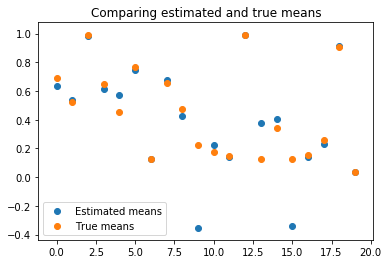

In [14]:
plt.figure()
plt.title('Comparing estimated and true means')
plt.scatter(np.arange(len(algo.means)), algo.means, label="Estimated means")
plt.scatter(np.arange(len(mab.means)), mab.means, label="True means")
plt.legend()
plt.show()

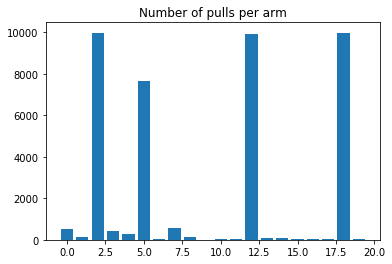

In [15]:
plt.bar(np.arange(len(algo.N)), algo.N)
plt.title('Number of pulls per arm')
plt.show()

## Plot the mean regret

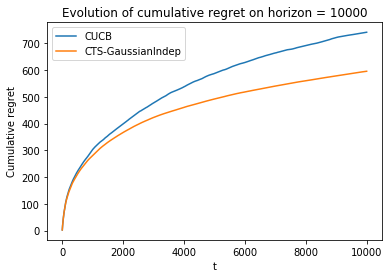

In [34]:
plt.figure()
for algo in algos:
    plt.plot(np.mean(regret[algo.name], axis=0), label=algo.name)
plt.title('Evolution of cumulative regret on horizon = {}'.format(horizon))
plt.ylabel('Cumulative regret')
plt.xlabel('t')
plt.legend()
plt.show()

Here we took almost independent signals so this result is far from surprising.